#__ANM-NCPOP-Demo__

Welcome to the repository for testing ANM-NCPOP! It focuses on Causal Model Discovery Problems in Learning Joint Multiple Dynamical Systems via Non-Commutative Polynomial Optimization(NCPOP).

# **ANM-NCPOP Process**
Define a function for solving the NCPO problems with given standard deviations of process noise and observtion noise, length of  estimation data and required relaxation level.

* Generate the artificial data
* Or standardise observational data
* Learn the Causal Structure beneath the observation data.
* Visualize the comparison between estimated and true graphs using a heatmap.
* Calculate Metrics.

Please follow the instructions for modelling ANM-NCPOP causality discovery
tool for both real data input and synthetic data generation.

## Synthetic_Data_Generation
* Weighted random DAG is produced according to num_nodes and num_edges
* Test rawdata is the time series generating from weighted random DAG and SEM type

## Real_Data_Standardization
* Causality Data can be stored as NumPy array x and matrix under DATASETS.
* Array x(F features, S samples and T time sets) and
* Matrix y(F features, F features)

# **Output Data Form**
* Metrics and heatmaps are saved under SUMMARY.

# **File_Save_Flow**
       
                                                         
                          Save_Path --- Results  -- Summary  -- Summary_Table
                                  |            |           |
                                  |            |            -- Summary_Details
                                  |            |           |
                                  |            |            -- Metrics(SHD, F1 score)
                                  |            |
                                  |             -- Datasets
                                  |            |
                                  |             -- Heatmap
                                  |
                                   -- Input_Data

#__Step 1: Get Start__

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/NCPOP/Causal_Models_Learning/Test/")
# os.chdir("/content/drive/MyDrive/Colab Notebooks/NCPOP/")

!export PYTHONPATH="$PYTHONPATH:/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks-data"
import os
os.environ['MOSEKLM_LICENSE_FILE']="/content/drive/MyDrive/Colab Notebooks/NCPOP/"

### for colab ###
# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this notebook's internal filesystem.
# Install MOSEK and ncpol2sdpa if not already installed
!pip install mosek
!pip install ncpol2sdpa

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##__Step 1.1: utils__

In [ ]:
class utils():
    '''
    A util with functions: Transferring between different names, Separate F1 Score name, Read causal matrix, Transfer matrix to mapping, Calculate F1 score, plot DAG

    '''

    def __init__(self, filename):
        self.filename = filename
    '''
    def saveName_transfer_to_filename(filename):

        parts = filename.split('_')
        name_without_extension = parts[:-1]
        parts_to_join = name_without_extension[:-2]

        # join with '_'
        result = '_'.join(parts_to_join)
        return result

    def dataName_transfer_to_filename(filename):
        parts = filename.split('_')
        name_without_extension = parts[:-1]
        parts_to_join = name_without_extension[:-4]

        # join with '_'
        result = '_'.join(parts_to_join)
        return result
    '''
    def separate_F1Score_name(save_name):
        '''Transfer saveName to filename

        Parameters
        ------------------------------------------------------------------------------------------------
        Name: str
                  file Name('F1_LinearSEM_GaussNoise_6Nodes_15Edges_TS.npz')
        Returns
        ------------------------------------------------------------------------------------------------
        filename: str
                  SEM Type, Noise Type, num Nodes, num Edges
        Examples
        -------------------------------------------------------------------------------------------------
        >>> sem, noise, nn, ne = utils.saperate_F1Score_name('F1_LinearSEM_GaussNoise_6Nodes_15Edges_TS.npz')
        >>> print(sem, noise, nn, ne)
        '''

        # file_name = 'F1_LinearSEM_GaussNoise_6Nodes_15Edges_TS.npz'
        s = re.split("\.", save_name)[0]
        # LinearSEM
        ss_SEM = re.split("_", s)[1]
        sem = re.split("SEM", ss_Noise)[0]

        # GaussNoise
        ss_Noise = re.split("_", s)[2]
        noise = re.split("Noise", ss_Noise)[0]

        # Nodes
        ss_Nodes = re.split("_", s)[3]
        nn = re.split("Nodes", ss_Nodes)[0]

        # Edges
        ss_Edges = re.split("_", s)[4]
        ne = re.split("Edges", ss_Edges)[0]

        return sem, noise, nn, ne

    def readable_File(FilePATH):
        read_Dir=os.listdir(FilePATH)
        count = 0
        readable_F = []
        for f in read_Dir:
            file = os.path.join(FilePATH, f)
            if os.path.isdir(file):
                count = count+1
            else:
                readable_F.append(f)
        return count,readable_F

    def Transfer_Matrix_To_Mapping(Causal_Matrix, nodes, Save_to_file):
        output = []
        with open(Save_to_file+'.txt', 'w') as f:
            for i in range(len(Causal_Matrix)):
                for j in range(len(Causal_Matrix)):
                    if Causal_Matrix.iloc[i][j] != 0:
                        f.write(f"{nodes[i]} {nodes[j]}\n")

    def read_graph(graph_file):
        with open(graph_file, "r") as file:
            lines = file.readlines()
        groundtruth = [tuple(line.strip().split()) for line in lines]
        return set(groundtruth)

    def f1score(predictions, groundtruth):
        union = groundtruth.union(predictions)
        intersection = groundtruth.intersection(predictions)
        tp = len(intersection)
        fp = len(union) - len(groundtruth)
        fn = len(union) - len(predictions)
        return tp / (tp + (fp + fn) / 2)

    def plot_dag(est_dag, true_dag, nodes, show=True, save_name=None):

        if isinstance(true_dag, np.ndarray):

            # trans diagonal element into 0
            for i in range(len(true_dag)):
                if est_dag[i][i] == 1:
                    est_dag[i][i] = 0
                if true_dag[i][i] == 1:
                    true_dag[i][i] = 0

            # set plot size
            fig, (ax1, ax2) = plt.subplots(figsize=(10, 3), ncols=2)

            ax1.set_title('est_graph')
            map1 = ax1.imshow(est_dag, cmap='binary', interpolation='nearest', vmin=-1, vmax=1)
            fig.colorbar(map1, ax=ax1)
            plt.xticks(ticks=np.arange(len(true_dag)), labels=nodes, rotation=80)
            plt.yticks(ticks=np.arange(len(true_dag)), labels=nodes)

            ax2.set_title('true_graph')
            map2 = ax2.imshow(true_dag, cmap='binary', interpolation='nearest', vmin=-1, vmax=1)
            fig.colorbar(map2, ax=ax2)
            plt.xticks(ticks=np.arange(len(true_dag)), labels=nodes, rotation=80)
            plt.yticks(ticks=np.arange(len(true_dag)), labels=nodes)
            plt.subplots_adjust(bottom=0.3)

            if save_name is not None:
                fig.savefig(save_name)
            if show:
                plt.show()

        elif isinstance(est_dag, np.ndarray):

            # trans diagonal element into 0
            for i in range(len(est_dag)):
                if est_dag[i][i] == 1:
                    est_dag[i][i] = 0

            # set plot size
            fig, ax1 = plt.subplots(figsize=(4, 3), ncols=1)

            ax1.set_title('est_graph')
            map1 = ax1.imshow(est_dag, cmap='binary', interpolation='nearest', vmin=-1, vmax=1)
            fig.colorbar(map1, ax=ax1)

            if save_name is not None:
                fig.savefig(save_name)
            if show:
                plt.show()

##__Step 1.2: CITest__

In [ ]:
from scipy import stats

class CITest(object):
    """
    Class of conditional independence test that contains multiple method

    """

    def _rbf_dot(x):

        n = x.shape[0]

        G = np.sum(x * x, 1).reshape(n, 1)
        Q = np.tile(G, (1, n))
        H = Q + G.T - 2 * np.dot(x, x.T)

        dists = Q + G.T - 2 * np.dot(x, x.T)
        dists = dists - np.tril(dists)
        dists = dists.reshape(n ** 2, 1)
        deg = np.sqrt(0.5 * np.median(dists[dists > 0]))

        H = np.exp(-H / 2 / (deg ** 2))

        return H

    def hsic_test(x, y, alpha=0.05, normalize=True):
        """Hilbert-Schmidt independence criterion

        HSIC with a Gaussian kernel for the independence test,
        where we used the gamma distribution as an approximation for the
        distribution of the HSIC.

        References
        ----------
        https://papers.nips.cc/paper/3201-a-kernel-statistical-test-of-independence.pdf
        """

        if normalize:
            x = (x - np.mean(x)) / np.std(x)
            y = (y - np.mean(y)) / np.std(y)

        n = x.shape[0]

        H = np.identity(n) - np.ones((n, n), dtype=float) / n
        K = CITest._rbf_dot(x)
        L = CITest._rbf_dot(y)
        Kc = np.dot(np.dot(H, K), H)
        Lc = np.dot(np.dot(H, L), H)

        testStat = np.sum(Kc.T * Lc) / n

        varHSIC = (Kc * Lc / 6) ** 2
        varHSIC = (np.sum(varHSIC) - np.trace(varHSIC)) / n / (n - 1)
        varHSIC = varHSIC * 72 * (n - 4) * (n - 5) / n / (n - 1) / (n - 2) / (n - 3)

        K = K - np.diag(np.diag(K))
        L = L - np.diag(np.diag(L))

        bone = np.ones((n, 1), dtype=float)
        muX = np.dot(np.dot(bone.T, K), bone) / n / (n - 1)
        muY = np.dot(np.dot(bone.T, L), bone) / n / (n - 1)
        mHSIC = (1 + muX * muY - muX - muY) / n
        al = mHSIC ** 2 / varHSIC
        bet = varHSIC * n / mHSIC

        thresh = stats.gamma.ppf(1 - alpha, al, scale=bet)[0][0]

        if testStat < thresh:
            return 1
        else:
            return 0

##__Step 1.3: Real data standardization__

In [ ]:
# from Data_Standardization import*
from pickle import TRUE
import os
import re
import numpy as np
import pandas as pd
import tarfile
from itertools import combinations
import urllib
import hashlib
from urllib.error import URLError
USER_AGENT = "gcastle/dataset"

'''
V18_N55_Wireless': V18_N55_Wireless,
            'V24_N439_Microwave': V24_N439_Microwave,
            'V25_N474_Microwave'
'''

def _check_exist(root, filename, files):
    path_exist = os.path.join(root, filename.split('.')[0])
    processed_folder_exists = os.path.exists(path_exist)
    if not processed_folder_exists:
        return False

    return all(
        _check_integrity(os.path.join(path_exist, file)) for file in files
    )

def _read_data(root, filename, files):
    path_exist = os.path.join(root, filename.split('.')[0])

    result = []
    for file in files:
        if file.split('.')[-1] == 'csv':
            file_path = os.path.join(path_exist, file)
            result.append(pd.read_csv(file_path))
        elif file.split('.')[-1] == 'npy':
            file_path = os.path.join(path_exist, file)
            result.append(np.load(file_path))

    if len(result) == 2:
        result.append(None)

    return result

def _check_integrity(fpath, md5=None):
    if not os.path.isfile(fpath):
        return False
    if md5 is None:
        return True

    md5f = hashlib.md5()
    with open(fpath, 'rb') as f:
        md5f.update(f.read())

    return md5 == md5f.hexdigest()


def _download(root, url, filename, md5):
    """Download the datasets if it doesn't exist already."""

    os.makedirs(root, exist_ok=True)

    # download files
    for mirror in url:
        filepath = "{}{}".format(mirror, filename)
        savegz = os.path.join(root, filename)
        try:
            print("Downloading {}".format(filepath))
            response = urllib.request.urlopen( \
                urllib.request.Request( \
                    filepath, headers={"User-Agent": USER_AGENT}))
            with open(savegz, "wb") as fh:
                fh.write(response.read())

            tar = tarfile.open(savegz)
            names = tar.getnames()
            for name in names:
                tar.extract(name, path=root)
            tar.close()
        except URLError as error:
            print("Failed to download (trying next):\n{}".format(error))
            continue
        break
    else:
        raise RuntimeError("Error downloading {}".format(filename))

    # check integrity of downloaded file
    if not _check_integrity(savegz, md5):
        raise RuntimeError("File not found or corrupted.")

def load_dataset(name='IID_Test', root=None, download=False):
    """
    A function for loading some well-known datasets.

    Parameters
    ----------
    name: class, default='IID_Test'
        Dataset name, independent and identically distributed (IID),
        Topological Hawkes Process (THP) and real datasets.
    root: str
        Root directory in which the dataset will be saved.
    download: bool
        If true, downloads the dataset from the internet and
        puts it in root directory. If dataset is already downloaded, it is not
        downloaded again.

    Return
    ------
    out: tuple
        true_graph_matrix: numpy.matrix
            adjacency matrix for the target causal graph.
        topology_matrix: numpy.matrix
            adjacency matrix for the topology.
        data: pandas.core.frame.DataFrame
            standard trainning dataset.
    """

    if name not in DataSetRegistry.meta.keys():
        raise ValueError('The dataset {} has not been registered, you can use'
                         ' ''castle.datasets.__builtin_dataset__'' to get registered '
                         'dataset list'.format(name))
    loader = DataSetRegistry.meta.get(name)()
    loader.load(root, download)
    return loader.data, loader.true_graph_matrix, loader.topology_matrix


class BuiltinDataSet(object):

    def __init__(self):
        self._data = None
        self._true_graph_matrix = None
        self._topology_matrix = None

    def load(self, *args, **kwargs):
        raise NotImplementedError

    @property
    def data(self):
        return self._data

    @property
    def true_graph_matrix(self):
        return self._true_graph_matrix

    @property
    def topology_matrix(self):
        return self._topology_matrix

class RealDataSet(BuiltinDataSet):

    def __init__(self):
        super().__init__()
        self.url = None
        self.tar_file = None
        self.md5 = None
        self.file_list = None

    def load(self, root=None, download=False):

        if root is None:
            root = './'

        if _check_exist(root, self.tar_file, self.file_list):
            self._data, self._true_graph_matrix, self._topology_matrix = \
                _read_data(root, self.tar_file, self.file_list)
            return

        if download:
            _download(root, self.url, self.tar_file, self.md5)

        if not _check_exist(root, self.tar_file, self.file_list):
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it.')

        self._data, self._true_graph_matrix, self._topology_matrix = \
            _read_data(root, self.tar_file, self.file_list)


class V18_N55_Wireless(RealDataSet):
    """
    A function for loading the real dataset: V18_N55_Wireless
    url: https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/18V_55N_Wireless.tar.gz
    """

    def __init__(self):
        super().__init__()
        self.url = ['https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/']
        self.tar_file = "18V_55N_Wireless.tar.gz"
        self.md5 = "36ee135b86c8dbe09668d9284c23575b"
        self.file_list = ['Alarm.csv', 'DAG.npy']


class V24_N439_Microwave(RealDataSet):
    """
    A function for loading the real dataset: V24_N439_Microwave
    url: https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/24V_439N_Microwave.tar.gz
    """

    def __init__(self):
        super().__init__()
        self.url = ['https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/']
        self.tar_file = "24V_439N_Microwave.tar.gz"
        self.md5 = "b4c8b32d34c04a86aa93c7259f7d086c"
        self.file_list = ['Alarm.csv', 'DAG.npy', 'Topology.npy']


class V25_N474_Microwave(RealDataSet):
    """
    A function for loading the real dataset: V25_N474_Microwave
    url: https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/25V_474N_Microwave.tar.gz
    """

    def __init__(self):
        super().__init__()
        self.url = ['https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/']
        self.tar_file = "25V_474N_Microwave.tar.gz"
        self.md5 = "51f43ed622d4b44ef6daf8fabf81e162"
        self.file_list = ['Alarm.csv', 'DAG.npy', 'Topology.npy']


class DataSetRegistry(object):
    '''
    A class for resgistering the datasets, in which each dataset
    can be loaded by 'load_dataset' api.
    '''

    meta = {'V18_N55_Wireless': V18_N55_Wireless,
            'V24_N439_Microwave': V24_N439_Microwave,
            'V25_N474_Microwave': V25_N474_Microwave}



class Real_Data_Standardization(object):
    '''
    A class for preparing data to simulate random (causal) DAG.

    Parameters
    ------------------------------------------------------------------------------------------------
    File_PATH: str
               Read file path, where the rawdata and true DAG are stored.
    File_NAME: str
               Read data name

    Returns
    ------------------------------------------------------------------------------------------------
    Input data: npz
            X: [F, S, T] time series T, sampled S times for F Features
            Y: True Causal Matrix
    File_PATH_Datasets:
            Route of saving test data

    Examples
    -------------------------------------------------------------------------------------------------
    >>> File_PATH = "../Test/Examples/Test_data/"
    >>> file_name = 'Telephone'
    >>> dt = Real_Data_Standardization(File_PATH, file_name)
    >>> dt.standardize_data()

    >>> File_PATH = "../Test/Datasets/Synthetic datasets/Krebs_Cycle/"
    >>> file_name = 'Krebs_Cycle'
    >>> dt = Real_Data_Standardization(File_PATH, file_name)
    >>> dt.standardize_data()

    >>> File_PATH = "../Test/Datasets/Real_data/Microwave/"
    >>> file_name = 'V24_N439_Microwave'
    >>> dt = Real_Data_Standardization(File_PATH, file_name)
    >>> dt.standardize_data()
    '''

    def __init__(self, File_PATH='Kreb_Cycles/', filename='Krebs_Cycle'):
        self.File_PATH = File_PATH
        self.filename = filename

    def standardize_data(self):
        ################################################  Create Ground Tier Folders #############################################
        self.File_PATH_Base = self.File_PATH +'Result_'+ self.filename +'/'

        ################################################  Create First Tier Folders #############################################
        self.File_PATH_Datasets = self.File_PATH_Base + 'Datasets_'+ self.filename +'/'
        if not os.path.exists(self.File_PATH_Datasets):
            os.makedirs(self.File_PATH_Datasets)
        print('ANM-NCPOP INFO: Created Datasets' + ' File!')

        Raw_data = Real_Data_Standardization.Produce_Rawdata(self)[0]
        true_dag = Real_Data_Standardization.Produce_Rawdata(self)[1]

        # save numpy to npz file
        nn = len(true_dag)
        ne = np.count_nonzero(true_dag)
        data_name = self.filename  +'_'+str(nn)+'Nodes_'+str(ne)+'Edges_TS'
        if self.filename in ['IID_Test','THP_Test','V18_N55_Wireless', 'V24_N439_Microwave', 'V25_N474_Microwave']:
            topology_matrix_devices = Real_Data_Standardization.Produce_Rawdata(self)[2]
            np.savez(self.File_PATH_Datasets + data_name +'.npz', x=Raw_data , y=true_dag , z=topology_matrix_devices)
        else:
            np.savez(self.File_PATH_Datasets + data_name +'.npz', x=Raw_data , y=true_dag)
        print('ANM-NCPOP INFO: Finished '+ data_name+' dataset standardization!')
        # return self.File_PATH_Datasets

    @staticmethod
    def Produce_Rawdata(self):

        def readable_File(FilePATH):
            read_Dir=os.listdir(FilePATH)
            count = 0
            readable_F = []
            for f in read_Dir:
                file = os.path.join(FilePATH, f)
                if os.path.isdir(file):
                    count = count+1
                else:
                    readable_F.append(f)
            return count,readable_F

        self.Read_File = readable_File(self.File_PATH)[1]

        # Website data
        if self.filename in ['IID_Test','THP_Test','V18_N55_Wireless', 'V24_N439_Microwave', 'V25_N474_Microwave']:
            Raw_data, true_dag, topology_matrix_devices  = load_dataset(self.filename, download=True)
            return Raw_data, true_dag, topology_matrix_devices

        else:
            # Check empty files under riute
            if len(self.Read_File ) == 0:
                raise ValueError('No Data Under the Current Route!')
            else:
                self.File_PATH_TS = self.File_PATH +self.filename +'_TS/'
                File_NAME = []
                File_TYPE = []
                # Delete files and list readable Files
                for i in self.Read_File:
                    File_NAME.append(re.split("\.", i)[0])
                    File_TYPE.append(re.split("\.", i)[1])

                ###################################### Deal with Two Dimensions Causality Data ###################################
                if self.filename+'.npz' in self.Read_File:
                    Test_data = np.load(self.File_PATH + self.filename+'.npz', allow_pickle=True)
                    Raw_data = Test_data['x']
                    true_dag = Test_data['y']
                    return Raw_data, true_dag

                elif self.filename+'.tar.gz' in self.Read_File:
                    # open file
                    file = tarfile.open(self.File_PATH + self.filename + '.tar.gz')
                    file_names = file.getnames()
                    # extract files
                    file.extractall(self.File_PATH)
                    file.close()
                    Raw_data = np.load(self.File_PATH+file_names[2])
                    true_dag = pd.read_csv(self.File_PATH+file_names[3])
                    return Raw_data, true_dag

                elif self.filename+'.csv' in self.Read_File:
                    Raw_data = pd.read_csv(self.File_PATH+ self.filename+'.csv', header=0, index_col=False)
                    true_dag = pd.read_csv(self.File_PATH+'true_graph.csv', header=0, index_col=0)
                    return Raw_data, true_dag

                ################################ Deal with Multi-dimensions Causality Data ###################################
                elif os.path.exists(self.File_PATH_TS):
                    read_Dir_TS=os.listdir(self.File_PATH_TS)
                    true_graph = np.load(self.File_PATH+'true_graph.npz')

                    # labels = ["FUMARATE", "GTP", "H2O", "CIS-ACONITATE", "MALATE",
                    # "OXALOACETATE", "FAD", "SUCCINYL-COA", "NAD",
                    #           "A-K-GLUTARATE", "GDP", "NADH", "CITRATE", "SUCCINATE",
                    # "ISOCITRATE", "ACETY-COA"]
                    #true_dag = pd.DataFrame(true_graph['arr_0'],  index=labels, columns=labels)
                    true_dag = pd.DataFrame(true_graph['arr_0'])

                    # print(true_dag)
                    lds = pd.read_csv(self.File_PATH_TS+ read_Dir_TS[0], delimiter='\t', index_col=0, header=None)
                    feature_name = np.array(lds.index)
                    feature_num = len(feature_name)
                    sample_num = len(read_Dir_TS)
                    T_num = lds.shape[1]
                    # if labels == feature_name:
                    Raw_data = np.zeros((feature_num, sample_num, T_num))
                    for ns in range(sample_num):
                        X = pd.read_csv(self.File_PATH_TS+ read_Dir_TS[ns], delimiter='\t', index_col=0, header=None)
                        X_trans = np.transpose(X)
                        for fn in range(feature_num):
                            Raw_data[fn, ns, :] = list(X_trans[feature_name[fn]])
                    return Raw_data, true_dag

                else:
                    raise ValueError('Unknown input data type.')


##__Step 1.4: Synthetic data generation__

In [ ]:
# from Generate_SyntheticData import*
from networkx.algorithms import bipartite
from scipy.special import expit as sigmoid
from itertools import combinations
from pickle import TRUE
from random import sample
from copy import deepcopy
from tqdm import tqdm
import numpy as np
import pandas as pd
import networkx as nx
import logging
import tarfile
import os
import re
# import time
import random


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

class Generate_Synthetic_Data(object):
    '''
    Simulate IID datasets for causal structure learning.

    Parameters
    ------------------------------------------------------------------------------------------------
    File_PATH
            Read data path
    n: int
            Number of samples for standard trainning dataset.
    T: int
            Number of timeseries for standard trainning dataset.
    method: str, (linear or nonlinear), default='linear'
            Distribution for standard trainning dataset.
    sem_type: str
            gauss, exp, gumbel, uniform, logistic (linear);
            mlp, mim, gp, gp-add, quadratic (nonlinear).
    nodes: series
            Notes of samples for standard trainning dataset.
    edges: series
            Edges of samples for standard training dataset.
    noise_scale: float
            Scale parameter of noise distribution in linear SEM.

    Returns
    ------------------------------------------------------------------------------------------------
    Raw_data: npz
            x：[F, S, T] sample time series
            y: true_dag
    File_PATH_Datasets:
            Route of saving test data

    Examples 1
    -------------------------------------------------------------------------------------------------
    >>> method = 'linear'
    >>> sem_type = 'gauss'
    >>> nodes = range(6,12,3)
    >>> edges = range(10,20,5)
    >>> T=200
    >>> num_datasets = 120
    >>> File_PATH = '../Test/Examples/Test_data/'
    >>> noise_scale = 1.0
    >>> _ts = Generate_Synthetic_Data(File_PATH, num_datasets, T, method, sem_type, nodes, edges, noise_scale)
    >>> _ts.genarate_data()

    Examples 2
    -------------------------------------------------------------------------------------------------
    >>> noise_type = {
    >>>     'nonlinear': ['gp-add', 'mlp', 'mim', 'gp', 'quadratic'],
    >>>     'linear':  ['gauss', 'exp', 'gumbel', 'uniform', 'logistic']
    >>> }
    >>> sem_type = ['linear', 'nonlinear']
    >>> nodes = range(6,12,3)
    >>> edges = range(10,20,5)
    >>> T=200
    >>> num_datasets = 120
    >>> File_PATH = '../Test/Examples/Test_data/'
    >>> noise_scale = 1.0

    >>> for m in sem_type :
    >>>   for s in noise_type[m]:
    >>>     _ts = Generate_Synthetic_Data(File_PATH, num_datasets, T, m, s, nodes, edges, noise_scale)
    >>>     print(File_PATH, num_datasets, T, m, s, nodes, edges, noise_scale)
    >>>     _ts.genarate_data()
    '''

    def __init__(self, File_PATH, n, T, method, sem_type, nodes, edges, noise_scale):
        self.File_PATH = File_PATH
        self.n = n
        self.T = T
        self.method = method
        self.sem_type =sem_type
        self.filename = self.method.capitalize()+'SEM_' + self.sem_type.capitalize() +'Noise'
        self.nodes = nodes
        self.edges = edges
        self.noise_scale = noise_scale

    def genarate_data(self):
        ################################################  Create Ground Tier Folders #############################################
        self.File_PATH_Base = self.File_PATH +'Result_'+ self.filename +'/'

        ################################################  Create First Tier Folders #############################################
        self.File_PATH_Datasets = self.File_PATH_Base + 'Datasets_'+ self.filename +'/'
        if not os.path.exists(self.File_PATH_Datasets):
            os.makedirs(self.File_PATH_Datasets)
        print('ANM-NCPOP INFO: Created Datasets' + ' File!')

        nodes_num = len(self.nodes)
        edges_num = len(self.edges)
        count = 0
        tqdm_csv=os.listdir(self.File_PATH_Datasets)
        while len(tqdm_csv) < nodes_num* edges_num:
            print('ANM-NCPOP INFO: Generating '+ self.filename + ' Dataset!')
            if self.method == 'linear':
                for nn in nodes:
                    for ne in edges:
                        count += 1
                        w = DAG.erdos_renyi(n_nodes=nn, n_edges=ne, seed=1)
                        self.B = (w != 0).astype(int)
                        self.XX = Generate_Synthetic_Data._simulate_linear_sem(self.B, self.n, self.T, self.sem_type, self.noise_scale)
                        data_name = self.filename+'_'+str(nn)+'Nodes_'+str(ne)+'Edges_TS'
                        np.savez(self.File_PATH_Datasets +data_name+'.npz', x=self.XX , y=self.B)
                        logging.info('ANM-NCPOP INFO: Finished synthetic dataset')
                        print('ANM-NCPOP INFO: '+ data_name + ' IS DONE!')
                print('ANM-NCPOP INFO: '+ str(count) + ' datasets are generated!')
                break
            elif self.method == 'nonlinear':
                for nn in nodes:
                    for ne in edges:
                        count += 1
                        w = DAG.erdos_renyi(n_nodes=nn, n_edges=ne, seed=1)
                        self.B = (w != 0).astype(int)
                        self.XX = Generate_Synthetic_Data._simulate_nonlinear_sem(self.B, self.n, self.T, self.sem_type, self.noise_scale)
                        data_name = self.filename+'_'+str(nn)+'Nodes_'+str(ne)+'Edges_TS'
                        np.savez(self.File_PATH_Datasets +data_name+'.npz', x=self.XX , y=self.B)
                        logging.info('ANM-NCPOP INFO: Finished synthetic dataset')
                        print('ANM-NCPOP INFO: '+ data_name + ' IS DONE!')
                print('ANM-NCPOP INFO: '+ str(count) + ' datasets are generated!')
                break
            else:
                raise ValueError('Unknown distribution type. Only linear and nonlinear types are accepted.')

            # time.sleep(30)
        print('ANM-NCPOP INFO: Finished '+ self.filename +' dataset generation, which can be found under route: '+ self.File_PATH_Datasets)

    @staticmethod
    def _simulate_linear_sem(W, n, T, sem_type, noise_scale=1.0):
        """
        Simulate samples from linear SEM with specified type of noise.
        For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

        Parameters
        ----------
        W: np.ndarray
            [d, d] weighted adj matrix of DAG.
        n: int
            Number of samples, n=inf mimics population risk.
        T: int
        Number of timeseries for standard trainning dataset.
        sem_type: str
            gauss, exp, gumbel, uniform, logistic.
        noise_scale: float
            Scale parameter of noise distribution in linear SEM.

        Return
        ------
        XX: np.ndarray
            [T, n, d] sample matrix, [d, d] if n and T=inf
        """
        def _simulate_single_equation(X, w, scale):
            """X: [n, num of parents], w: [num of parents], x: [n]"""
            if sem_type == 'gauss':
                z = np.random.normal(scale=scale, size=T)
                x = X @ w + z
            elif sem_type == 'exp':
                z = np.random.exponential(scale=scale, size=T)
                x = X @ w + z
            elif sem_type == 'gumbel':
                z = np.random.gumbel(scale=scale, size=T)
                x = X @ w + z
            elif sem_type == 'uniform':
                z = np.random.uniform(low=-scale, high=scale, size=T)
                x = X @ w + z
            elif sem_type == 'logistic':
                x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
            else:
                raise ValueError('Unknown sem type. In a linear model, \
                                 the options are as follows: gauss, exp, \
                                 gumbel, uniform, logistic.')
            return x

        d = W.shape[0]
        if noise_scale is None:
            scale_vec = np.ones(d)
        elif np.isscalar(noise_scale):
            scale_vec = noise_scale * np.ones(d)
        else:
            if len(noise_scale) != d:
                raise ValueError('noise scale must be a scalar or has length d')
            scale_vec = noise_scale
        G_nx =  nx.from_numpy_array(W, create_using=nx.DiGraph)
        if not nx.is_directed_acyclic_graph(G_nx):
            raise ValueError('W must be a DAG')
        if np.isinf(T):  # population risk for linear gauss SEM
            if sem_type == 'gauss':
                # make 1/d X'X = true cov
                X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
                return X
            else:
                raise ValueError('population risk not available')
        # empirical risk
        ordered_vertices = list(nx.topological_sort(G_nx))
        assert len(ordered_vertices) == d
        X = np.zeros([T, d])
        XX = np.zeros((d, n, T))
        for j in ordered_vertices:
            parents = list(G_nx.predecessors(j))
            X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
        for ns in range(n):
            XX[:, ns] = np.transpose(X)
        return XX

    @staticmethod
    def _simulate_nonlinear_sem(W, n, T, sem_type, noise_scale=1.0):
        """
        Simulate samples from nonlinear SEM.

        Parameters
        ----------
        B: np.ndarray
            [d, d] binary adj matrix of DAG.
        n: int
            Number of samples.
        T: int
            Number of times.
        sem_type: str
            mlp, mim, gp, gp-add, or quadratic.
        noise_scale: float
            Scale parameter of noise distribution in linear SEM.

        Return
        ------
        XX: np.ndarray
            [d, n, T] sample matrix
        """
        if sem_type == 'quadratic':
            return Generate_SyntheticData._simulate_quad_sem(W, T, noise_scale)

        def _simulate_single_equation(X, scale):
            """X: [n, num of parents], x: [n]"""
            z = np.random.normal(scale=scale, size=n)
            pa_size = X.shape[1]
            if pa_size == 0:
                return z
            if sem_type == 'mlp':
                hidden = 100
                W1 = np.random.uniform(low=0.5, high=2.0, size=[pa_size, hidden])
                W1[np.random.rand(*W1.shape) < 0.5] *= -1
                W2 = np.random.uniform(low=0.5, high=2.0, size=hidden)
                W2[np.random.rand(hidden) < 0.5] *= -1
                x = sigmoid(X @ W1) @ W2 + z
            elif sem_type == 'mim':
                w1 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
                w1[np.random.rand(pa_size) < 0.5] *= -1
                w2 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
                w2[np.random.rand(pa_size) < 0.5] *= -1
                w3 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
                w3[np.random.rand(pa_size) < 0.5] *= -1
                x = np.tanh(X @ w1) + np.cos(X @ w2) + np.sin(X @ w3) + z
            elif sem_type == 'gp':
                from sklearn.gaussian_process import GaussianProcessRegressor
                gp = GaussianProcessRegressor()
                x = gp.sample_y(X, random_state=None).flatten() + z
            elif sem_type == 'gp-add':
                from sklearn.gaussian_process import GaussianProcessRegressor
                gp = GaussianProcessRegressor()
                x = sum([gp.sample_y(X[:, i, None], random_state=None).flatten()
                        for i in range(X.shape[1])]) + z
            else:
                raise ValueError('Unknown sem type. In a nonlinear model, \
                                 the options are as follows: mlp, mim, \
                                 gp, gp-add, or quadratic.')
            return x

        B = (W != 0).astype(int)
        d = B.shape[0]
        if noise_scale is None:
            scale_vec = np.ones(d)
        elif np.isscalar(noise_scale):
            scale_vec = noise_scale * np.ones(d)
        else:
            if len(noise_scale) != d:
                raise ValueError('noise scale must be a scalar or has length d')
            scale_vec = noise_scale

        X = np.zeros([n, d])
        G_nx =  nx.from_numpy_array(B, create_using=nx.DiGraph)
        ordered_vertices = list(nx.topological_sort(G_nx))
        assert len(ordered_vertices) == d
        for j in ordered_vertices:
            parents = list(G_nx.predecessors(j))
            X[:, j] = _simulate_single_equation(X[:, parents], scale_vec[j])
        return X
        XX = np.zeros((d, n, T))
        for ns in range(n):
            XX[:, ns] = np.transpose(X)
        return XX



class DAG(object):
    '''
    A class for simulating random (causal) DAG, where any DAG generator
    method would return the weighed/binary adjacency matrix of a DAG.
    Besides, we recommend using the python package "NetworkX"
    to create more structures types.
    '''

    @staticmethod
    def _random_permutation(M):
        # np.random.permutation permutes first axis only
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    @staticmethod
    def _random_acyclic_orientation(B_und):
        B = np.tril(DAG._random_permutation(B_und), k=-1)
        B_perm = DAG._random_permutation(B)
        return B_perm

    @staticmethod
    def _graph_to_adjmat(G):
        return nx.to_numpy_array(G)

    @staticmethod
    def _BtoW(B, d, w_range):
        U = np.random.uniform(low=w_range[0], high=w_range[1], size=[d, d])
        U[np.random.rand(d, d) < 0.5] *= -1
        W = (B != 0).astype(float) * U
        return W

    @staticmethod
    def _low_rank_dag(d, degree, rank):
        """
        Simulate random low rank DAG with some expected degree.

        Parameters
        ----------
        d: int
            Number of nodes.
        degree: int
            Expected node degree, in + out.
        rank: int
            Maximum rank (rank < d-1).

        Return
        ------
        B: np.nparray
            Initialize DAG.
        """
        prob = float(degree) / (d - 1)
        B = np.triu((np.random.rand(d, d) < prob).astype(float), k=1)
        total_edge_num = np.sum(B == 1)
        sampled_pa = sample(range(d - 1), rank)
        sampled_pa.sort(reverse=True)
        sampled_ch = []
        for i in sampled_pa:
            candidate = set(range(i + 1, d))
            candidate = candidate - set(sampled_ch)
            sampled_ch.append(sample(candidate, 1)[0])
            B[i, sampled_ch[-1]] = 1
        remaining_pa = list(set(range(d)) - set(sampled_pa))
        remaining_ch = list(set(range(d)) - set(sampled_ch))
        B[np.ix_(remaining_pa, remaining_ch)] = 0
        after_matching_edge_num = np.sum(B == 1)

        # delta = total_edge_num - after_matching_edge_num
        # mask B
        maskedB = B + np.tril(np.ones((d, d)))
        maskedB[np.ix_(remaining_pa, remaining_ch)] = 1
        B[maskedB == 0] = 1

        remaining_ch_set = set([i + d for i in remaining_ch])
        sampled_ch_set = set([i + d for i in sampled_ch])
        remaining_pa_set = set(remaining_pa)
        sampled_pa_set = set(sampled_pa)

        edges = np.transpose(np.nonzero(B))
        edges[:, 1] += d
        bigraph = nx.Graph()
        bigraph.add_nodes_from(range(2 * d))
        bigraph.add_edges_from(edges)
        M = nx.bipartite.maximum_matching(bigraph, top_nodes=range(d))
        while len(M) > 2 * rank:
            keys = set(M.keys())
            rmv_cand = keys & (remaining_pa_set | remaining_ch_set)
            p = sample(rmv_cand, 1)[0]
            c = M[p]
            # destroy p-c
            bigraph.remove_edge(p, c)
            M = nx.bipartite.maximum_matching(bigraph, top_nodes=range(d))

        new_edges = np.array(bigraph.edges)
        for i in range(len(new_edges)):
            new_edges[i,].sort()
        new_edges[:, 1] -= d

        BB = np.zeros((d, d))
        B = np.zeros((d, d))
        BB[new_edges[:, 0], new_edges[:, 1]] = 1

        if np.sum(BB == 1) > total_edge_num:
            delta = total_edge_num - rank
            BB[sampled_pa, sampled_ch] = 0
            rmv_cand_edges = np.transpose(np.nonzero(BB))
            if delta <= 0:
                raise RuntimeError(r'Number of edges is below the rank, please \
                                   set a larger edge or degree \
                                   (you can change seed or increase degree).')
            selected = np.array(sample(rmv_cand_edges.tolist(), delta))
            B[selected[:, 0], selected[:, 1]] = 1
            B[sampled_pa, sampled_ch] = 1
        else:
            B = deepcopy(BB)

        B = B.transpose()
        return B

    @staticmethod
    def erdos_renyi(n_nodes, n_edges, weight_range=None, seed=None):

        assert n_nodes > 0
        set_random_seed(seed)
        # Erdos-Renyi
        creation_prob = (2 * n_edges) / (n_nodes ** 2)
        G_und = nx.erdos_renyi_graph(n=n_nodes, p=creation_prob, seed=seed)
        B_und = DAG._graph_to_adjmat(G_und)
        B = DAG._random_acyclic_orientation(B_und)
        if weight_range is None:
            return B
        else:
            W = DAG._BtoW(B, n_nodes, weight_range)
        return W

    @staticmethod
    def scale_free(n_nodes, n_edges, weight_range=None, seed=None):

        assert (n_nodes > 0 and n_edges >= n_nodes and n_edges < n_nodes * n_nodes)
        set_random_seed(seed)
        # Scale-free, Barabasi-Albert
        m = int(round(n_edges / n_nodes))
        G_und = nx.barabasi_albert_graph(n=n_nodes, m=m)
        B_und = DAG._graph_to_adjmat(G_und)
        B = DAG._random_acyclic_orientation(B_und)
        if weight_range is None:
            return B
        else:
            W = DAG._BtoW(B, n_nodes, weight_range)
        return W

    @staticmethod
    def bipartite(n_nodes, n_edges, split_ratio = 0.2, weight_range=None, seed=None):

        assert n_nodes > 0
        set_random_seed(seed)
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        n_top = int(split_ratio * n_nodes)
        n_bottom = n_nodes -  n_top
        creation_prob = n_edges/(n_top*n_bottom)
        G_und = bipartite.random_graph(n_top, n_bottom, p=creation_prob, directed=True)
        B_und = DAG._graph_to_adjmat(G_und)
        B = DAG._random_acyclic_orientation(B_und)
        if weight_range is None:
            return B
        else:
            W = DAG._BtoW(B, n_nodes, weight_range)
        return W

    @staticmethod
    def hierarchical(n_nodes, degree=5, graph_level=5, weight_range=None, seed=None):

        assert n_nodes > 1
        set_random_seed(seed)
        prob = float(degree) / (n_nodes - 1)
        B = np.tril((np.random.rand(n_nodes, n_nodes) < prob).astype(float), k=-1)
        point = sample(range(n_nodes - 1), graph_level - 1)
        point.sort()
        point = [0] + [x + 1 for x in point] + [n_nodes]
        for i in range(graph_level):
            B[point[i]:point[i + 1], point[i]:point[i + 1]] = 0
        if weight_range is None:
            return B
        else:
            W = DAG._BtoW(B, n_nodes, weight_range)
        return W

    @staticmethod
    def low_rank(n_nodes, degree=1, rank=5, weight_range=None, seed=None):

        assert n_nodes > 0
        set_random_seed(seed)
        B = DAG._low_rank_dag(n_nodes, degree, rank)
        if weight_range is None:
            return B
        else:
            W = DAG._BtoW(B, n_nodes, weight_range)
        return W


##__Step 1.5: ANM-NCPOP algorithm__

In [ ]:
import os
import re
import csv
import sys
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import scale
from itertools import combinations
from ncpol2sdpa import*



class Anm_ncpop_test(object):
    '''
    A class for simulating (causal) DAG, where the true DAG is a weighed/binary adjacency matrix based on ground truth.

    Parameters
    ------------------------------------------------------------------------------------------------
    File_PATH: str
            Read file path
    File_NAME: str
            Read data name
    File_PATH_Summary_Datails: str
            Save file path
    datasize: array
            Series of datasizes for standard training time series
    Timesize: array
            Series of timesets for standard training time series

    Returns
    ------------------------------------------------------------------------------------------------
    Metrics DAG: np.matrix
            heatmap between estimate DAG matrix and true DAG
    Casaul Metrics: np.matrix
            estimate DAG matrix
    Summary scores table: pd.dataframe
           col_names = ['Datasize','Timesets', 'Duration', 'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
    Summary table: pd.dataframe
           col_names = ['DataSize', 'Timesets', 'F1_Score', 'Duration']

    Examples
    -------------------------------------------------------------------------------------------------
    >>> # filename = LinearSEM_GaussNoise
    >>> # data_name = LinearSEM_GaussNoise_6Nodes_15Edges_TS
    >>> # save_name = LinearSEM_GaussNoise_6Nodes_15Edges_TS_15Datasize_5Timesets

    >>> datasize = range(5, 40, 5)
    >>> Timesize = range(3, 6, 1)
    >>> File_PATH_Base = 'Test/Examples/Test_data/'
    >>> File_PATH_Summary_Datails = 'Test/Examples/Test_data/Summary'
    >>> File_PATH = File_PATH
    >>> Data_NAME = 'LinearSEM_GaussNoise_6Nodes_15Edges_TS.npz'
    >>> # Data_NAME = 'Krebs_Cycle_16Nodes_43Edges_TS.npz'
    >>> rt = Anm_ncpop_test(File_PATH_Base, Data_NAME, File_PATH_Summary_Datails, datasize, Timesize)
    >>> rt.Ancpop()

    '''
    def __init__(self, File_PATH = None, filename= None, Datasize=range(5, 40, 5), Timeset= range(3, 6, 1)):
        self.File_PATH = File_PATH
        self.Datasize =  Datasize
        self.Timeset = Timeset
        self.filename = filename


    def Ancpop(self):
        ################################################  Create Ground Tier Folders #############################################
        self.File_PATH_Base = self.File_PATH +'Result_'+ self.filename +'/'
        if not os.path.exists(self.File_PATH_Base):
            os.makedirs(self.File_PATH_Base)
        print('ANM-NCPOP INFO: Created Basement'+ ' File!')

        ################################################  Create First Tier Folders #############################################
        self.File_PATH_Summary = self.File_PATH_Base + 'Summary_'+ self.filename +'/'
        if not os.path.exists(self.File_PATH_Summary):
            os.makedirs(self.File_PATH_Summary)
        print('ANM-NCPOP INFO: Created Summary'+ ' File!')

        self.File_PATH_Datasets = self.File_PATH_Base + 'Datasets_'+ self.filename +'/'
        if not os.path.exists(self.File_PATH_Datasets):
            print('ANM-NCPOP INFO: Put data under route' + self.File_PATH_Base + 'or go back to input data step!')
            os.makedirs(self.File_PATH_Datasets)

        print('ANM-NCPOP INFO: Created Datasets' + ' File!')

        ################################################  Create Second Tier Folders #############################################
        self.File_PATH_Summary_Datails = self.File_PATH_Summary + 'Summary_Datails_'+self.filename +'/'
        self.File_PATH_MetricsDAG = self.File_PATH_Summary +'MetricsDAG_'+self.filename +'/'
        if not os.path.exists(self.File_PATH_Summary_Datails):
            os.makedirs(self.File_PATH_Summary_Datails)
        print('ANM-NCPOP INFO: Created Summary_Datails'+ ' File!')
        if not os.path.exists(self.File_PATH_MetricsDAG):
            os.makedirs(self.File_PATH_MetricsDAG)
        print('ANM-NCPOP INFO: Created MetricsDAG'+ ' File!')

        ################################################  Analyzing Data under Datasets ###############################
        tqdm=os.listdir(self.File_PATH_Summary_Datails)
        read_Dir=os.listdir(self.File_PATH_Datasets)
        while len(tqdm)!= len(read_Dir):
            for d_name in read_Dir:
                # print(file_f)
                data_name = re.split("\.", d_name)[0]
                # filename = utils.saveName_transfer_to_filename(data_name)
                df_F1 = self.File_PATH_Summary_Datails + 'F1_'+ data_name +'.csv'
                if not os.path.exists(df_F1):
                    Rawdata = np.load(self.File_PATH_Datasets+data_name+'.npz')
                    F1 = self.Ancpop_estimate(self, Rawdata, data_name)
                print('ANM-NCPOP INFO: Finished '+ data_name+' Analyzing!')
        print('ANM NCPOP INFO: Finished simulations!')

    @staticmethod
    def Ancpop_estimate(self, Rawdata, data_name):
        Raw_data = Rawdata['x']
        true_dag = Rawdata['y']
        # duration_anm_ncpop = []
        f1_anm_ncpop = []
        df = pd.DataFrame(columns=['DataSize', 'TimeSets', 'Duration', 'F1_Score', 'SHD'])
        for i in self.Datasize:
            for j in self.Timeset:
                data = Raw_data[:, :i, :j]
                t_start = time.time()
                # Test ANM-NCPOP
                anmNCPO = ANM_NCPO(alpha=0.05)
                anmNCPO.learn(data = data)
                # Save estimate causal_matrix
                save_name = data_name+'_' + str(i) + 'Datasize_'+str(j) +'Timesets'

                pd.DataFrame(anmNCPO.causal_matrix).to_csv(self.File_PATH_MetricsDAG + 'Causal_matrix_' + save_name+'.csv',index=False)

                # Plot predict_dag and true_dag
                nodes = ["FUMARATE", "GTP", "H2O", "CIS-ACONITATE", "MALATE", "OXALOACETATE", "FAD", "SUCCINYL-COA", "NAD", "A-K-GLUTARATE", "GDP", "NADH", "CITRATE", "SUCCINATE", "ISOCITRATE", "ACETY-COA"]
                utils.plot_dag(anmNCPO.causal_matrix, true_dag, nodes, show=True, save_name=self.File_PATH_MetricsDAG + save_name+'.png')
                # GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name = self.File_PATH_MetricsDAG + save_name+'.png')

                # Cal metrics
                utils.Transfer_Matrix_To_Mapping(pd.DataFrame(anmNCPO.causal_matrix), nodes, data_name+'_groundtruth')
                utils.Transfer_Matrix_To_Mapping(pd.DataFrame(true_dag), nodes, data_name+'_predict')
                G_tar = utils.read_graph(data_name+'_groundtruth.txt')
                G_pred = utils.read_graph(data_name+'_predict.txt')
                edit_distances = len(G_tar.union(G_pred)) - len(G_tar.intersection(G_pred))
                f1_scores = utils.f1score(G_pred, G_tar)
                dict1 = {'DataSize':i, 'TimeSets':j, 'Duration':time.time()-t_start, 'F1_Score': f1_scores, 'SHD':edit_distances}
                df = pd.concat([df, pd.DataFrame([dict1])])
                print('ANM-NCPOP INFO: ' + save_name +' is done!'+'F1 Score is '+ str(f1_scores)+'.')
                print('ANM-NCPOP INFO: Time Duration is '+ str(time.time()-t_start))
        df.to_csv(self.File_PATH_MetricsDAG + 'Scores_'+data_name+'.csv', index=False)
        df.to_csv(self.File_PATH_Summary_Datails + 'F1_'+ data_name +'.csv', index=False)
        # df_F1 = df['DataSize', 'TimeSets', 'Duration', 'F1_Score']
        ## df_F1 = pd.DataFrame({'F1_Score':f1_anm_ncpop, 'Duration':duration_anm_ncpop})
        #df_F1.to_csv(self.File_PATH_Summary_Datails + 'F1_'+data_name+'.csv',index=False)


class NCPOLR(object):
    """Estimator based on NCPOP Regressor

    References
    ----------
    Quan Zhou https://github.com/Quan-Zhou/Proper-Learning-of-LDS/blob/master/ncpop/functions.py

    Examples
    --------
    >>> import numpy as np
    >>> Y=[1,2,3]
    >>> X=[1,2,3]
    >>> ncpolr = NCPOLR()
    >>> y_pred = ncpolr.estimate(X, Y)
    >>> print(y_pred)
    """

    def __init__(self, **kwargs):
        super(NCPOLR, self).__init__()

    def estimate(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        X : array
            Variable seen as cause
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """

        T = len(Y)
        level = 1

        # Decision Variables
        # f=G*x+n以前是最小化n**2，现在就直接最小化p
        # G是系数
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        # f是y的估计值
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)
        # n是残差
        n = generate_operators("m", n_vars=T, hermitian=True, commutative=False)
        # p是n的绝对值
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.5*sum(p[i] for i in range(T))

        # Constraints
        ine1 = [f[i] - G*X[i] - n[i] for i in range(T)]
        ine2 = [-f[i] + G*X[i] + n[i] for i in range(T)]
        # fp和n的关系通过加新的限制条件p>n 和p>-n来实现
        ine3 = [p[i]-n[i] for i in range(T)]
        ine4 = [p[i]+n[i] for i in range(T)]
        ines = ine1+ine2+ine3+ine4

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,f,n,p]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')
        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[n[i]])
            print(est_noise)
            return est_noise
        else:
            print('Cannot find feasible solution.')
            return

    def estimate2(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        X : array
            Variable seen as cause
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """

        T = len(Y)
        level = 1

        # Decision Variables
        A = generate_perators("A", n_vars=1, hermitian=True, commutative=False)[0]
        B = generate_operators("B", n_vars=1, hermitian=True, commutative=False)[0]
        phi = generate_operators("phi", n_vars=T+1, hermitian=True, commutative=False)
        w = generate_operators("w", n_vars=T, hermitian=True, commutative=False)
        v = generate_operators("v", n_vars=T, hermitian=True, commutative=False)
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.0005*sum(p[i]**2 for i in range(T)) + 0.0001*sum(q[i]**2 for i in range(T))

        # Constraints
        ine1 = [phi[t+1] - A*phi[t] - w[t] for t in range(T)]
        ine2 = [-phi[t+1] + A*phi[t] + w[t] for t in range(T)]
        ine3 = [f[t] - B*phi[t+1] - v[t] for t in range(T)]
        ine4 = [-f[t] + B*phi[t+1] + v[t] for t in range(T)]
        ines = ine1+ine2+ine3+ine4


        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([A, B, f, w, phi, v]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')
        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[n[i]])
            print(est_noise)
            return est_noise
        else:
            print('Cannot find feasible solution.')
            return

class ANM_NCPO():
    """
    Nonlinear causal discovery with additive noise models

    Use Estimator based on NCPOP Regressor and independent Gaussian noise,
    For the independence test, we implemented the HSIC with a Gaussian kernel,
    where we used the gamma distribution as an approximation for the
    distribution of the HSIC under the null hypothesis of independence
    in order to calculate the p-value of the test result.

    References
    ----------
    Hoyer, Patrik O and Janzing, Dominik and Mooij, Joris M and Peters,
    Jonas and Schölkopf, Bernhard,
    "Nonlinear causal discovery with additive noise models", NIPS 2009

    Parameters
    ----------
    alpha : float, default 0.05
        significance level be used to compute threshold

    Attributes
    ----------
    causal_matrix : array like shape of (n_features, n_features)
        Learned causal structure matrix.

    Examples
    --------
    >>> import numpy as np

    >>> rawdata = np.load('dataset/linear_gauss_6nodes_15edges.npz', allow_pickle=True)
    >>> data = rawdata['x']

    >>> anmNCPO = ANM_NCPO(alpha=0.05)
    >>> anmNCPO.learn(data=data)
    >>> print(anmNCPO.causal_matrix)
    """

    def __init__(self, columns=None, alpha=0.05):
        super(ANM_NCPO, self).__init__()
        self.alpha = alpha

    def learn(self, data, columns=None,regressor=NCPOLR(),test_method=CITest.hsic_test, **kwargs):
        """Set up and run the ANM_NCPO algorithm.

        Parameters
        ----------
        data: numpy.ndarray or Tensor
            Training data.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOLR.
            If user defined, must implement `estimate` method. such as : `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as : `test_method(x, y, alpha=0.05)`
        """

        self.regressor = regressor

        node_num = data.shape[0]
        self.causal_matrix = np.zeros((node_num, node_num))

        for i, j in combinations(range(node_num), 2):
            x = data[i, :, :]
            y = data[j, :, :]
            xx = x.reshape((-1, 1))
            yy = y.reshape((-1, 1))

            flag = test_method(xx, yy, alpha=self.alpha)
            if flag == 1:
                continue
            # test x-->y
            flag = self.anmNCPO_estimate(x, y, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[i, j] = 1
            # test y-->x
            flag = self.anmNCPO_estimate(y, x, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[j, i] = 1

    def anmNCPO_estimate(self, x, y, regressor=NCPOLR(), test_method=CITest.hsic_test):
        """Compute the fitness score of the ANM_NCPOP Regression model in the x->y direction.

        Parameters
        ----------
        x: array
            Variable seen as cause
        y: array
            Variable seen as effect
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOP.
            If user defined, must implement `estimate` method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        Returns
        -------
        out: int, 0 or 1
            If 1, residuals n is independent of x, then accept x --> y
            If 0, residuals n is not independent of x, then reject x --> y

        Examples
        --------
        >>> import numpy as np
        >>> rawdata = np.load('dataset/linear_gauss_6nodes_15edges.npz', allow_pickle=True)
        >>> data = rawdata['x'][:20]
        >>> true_dag = rawdata['y'][:20]
        >>> data = pd.DataFrame(data)
        >>> y=np.asarray(data[0])
        >>> x=np.asarray(data[1])
        >>> flag = anmNCPO_estimate(x, y, regressor = NCPOLR(), test_method=hsic_test)
        """

        x = scale(x).reshape(-1)
        y = scale(y).reshape(-1)

        x_res = regressor.estimate(x, y)
        flag = test_method(np.asarray(x_res).reshape((-1, 1)), np.asarray(x).reshape((-1, 1)), alpha=self.alpha)
        print(flag)

        return flag



##__Step 1.6: Ancpop_Simulation__

In [ ]:
import os
import re
import csv
import time
import pandas as pd
import numpy as np

class Ancpop_Simulation(object):
    '''
    A class for simulating random (causal) DAG based on synthetic datasets, where any DAG generator
    self.method would return the weighed/binary adjacency matrix of a DAG.

    Parameters
    -----------------------------------------------------------------------------------------------
    method: str, (linear or nonlinear), default='linear'
        Distribution for standard training time series.
    File_PATH: str
        Save file path
    sem_type: str
        gauss, exp, gumbel, uniform, logistic (linear);
        mlp, mim, gp, gp-add, quadratic (nonlinear).
    Data_st: int
        Start number of samples for standard training time series
    Data_ed: int
        stop number of samples for standard training time series
    Datastep: int
        step number of samples for standard training time series
    Time_st: int
        Start number of timesets for standard training time series
    Time_ed: int
        stop number of timesets for standard training time series
    Timestep: int
        step number of timesets for standard training time series

    Returns
    ------------------------------------------------------------------------------------------------
    Summary table: pd.dataframe
            col_names = ['SEM','Noise','Nodes','Edges','DataSize','Timesets','F1_Score', 'Duration']

    Examples
    -------------------------------------------------------------------------------------------------
    >>>
    >>> File_PATH = 'Test/Results'
    >>> Nodes = range(6, 15, 3)
    >>> Edges = range(10, 20, 5)
    >>> datasize = range(5, 40, 5)
    >>> Timesize = range(3, 6, 1)
    >>> st = Ancpop_Simulation(File_PATH, method, sem_type, Nodes, Edges, datasize, Timesize)
    >>> st.Ancpop_simulation_Test()
    '''

    def __init__(self, File_PATH, filename):
        self.File_PATH = File_PATH
        self.filename = filename

    @staticmethod
    def Ancpop_simulation_Test(self):
        ################################################  Create Ground Tier Folders #############################################
        self.File_PATH_Base = self.File_PATH +'Result_'+ self.filename +'/'
        if not os.path.exists(self.File_PATH_Base):
            os.makedirs(self.File_PATH_Base)
        print('ANM-NCPOP INFO: Created Basement'+ ' File!')

        ################################################  Create First Tier Folders #############################################
        self.File_PATH_Heatmap = self.File_PATH_Base + 'Heatmap_'+ self.filename + '/'
        if not os.path.exists(self.File_PATH_Heatmap):
            os.makedirs(self.File_PATH_Heatmap )
        print('ANM-NCPOP INFO: Created Heatmap_GetReady'+ ' File!')

        ################################################  Create Second Tier Folders under Summary ###############################
        self.File_PATH_Summary_Tables = self.File_PATH_Heatmap +'Summary_'+self.filename +'/'
        if not os.path.exists(self.File_PATH_Summary_Tables):
            os.makedirs(self.File_PATH_Summary_Tables)
        print('ANM-NCPOP INFO: Created Summary_Tables'+ ' File!')

        self.Summary_Results(self)

    @staticmethod
    def Summary_Results(self):
        ###############################################  Summarize results ###############################
        f1_anm_ncpop = pd.DataFrame()
        for summary_f in range(len(tqdm)):
            df_combined = []
            File_PATH = os.path.join(self.File_PATH_Summary_Datails,tqdm[summary_f])
            df = pd.read_csv(File_PATH)
            # file_name = 'F1_LinearSEM_GaussNoise_6Nodes_15Edges_TS.npz'
            df['SEM', 'Noise', 'Nodes', 'Edges'] = utils.separate_F1Score_name(tqdm[summary_f])
            df_combined = pd.concat([df_combined, df], ignore_index=True, axis=1)

            f1_anm_ncpop_nan = df.loc[:,'F1_Score']
            if len([f1_anm_ncpop_nan == 0]) == len(f1_anm_ncpop_nan):
              f1_anm_ncpop = 0.2
            else:
              f1_anm_ncpop = round(np.nanmean(f1_anm_ncpop_nan), 3)
            f1_result = pd.DataFrame(df_combined, columns=['SEM','Noise','Nodes','Edges','DataSize','Timesets','F1_Score', 'Duration'])
        f1_result.to_csv(self.Table_PATH_Summary+'summary.csv',index=False)
        return f1_result



#__Step 2: Test Real Data__

##__Step 2.1: Compress Krebs_Cycle times series__

In [ ]:
# Krebs_Cycle
File_PATH = "../Test/Datasets/Synthetic datasets/Krebs_Cycle/"
file_name = 'Krebs_Cycle'
dt = Real_Data_Standardization(File_PATH, file_name)
dt.standardize_data()


ANM-NCPOP INFO: Created Datasets File!
ANM-NCPOP INFO: Finished Krebs_Cycle_16Nodes_43Edges_TS dataset standardization!


##__Step 2.2: Test ANM-NCPOP__

ANM-NCPOP INFO: Created Basement File!
ANM-NCPOP INFO: Created Summary File!
ANM-NCPOP INFO: Created Datasets File!
ANM-NCPOP INFO: Created Summary_Datails File!
ANM-NCPOP INFO: Created MetricsDAG File!
The problem has 46 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 25/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

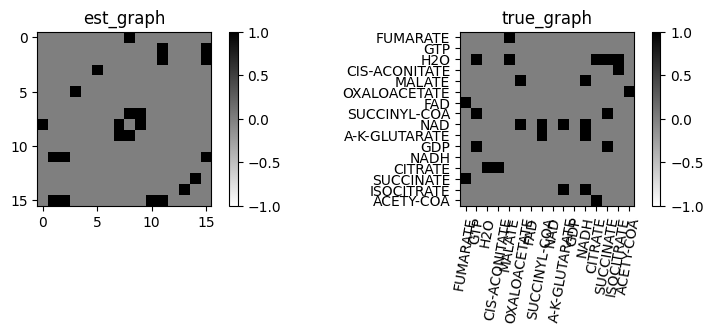

<ipython-input-6-cb497a4c4bf6>:146: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([dict1])])


ANM-NCPOP INFO: Krebs_Cycle_16Nodes_43Edges_TS_3Datasize_5Timesets is done!F1 Score is 0.12.
ANM-NCPOP INFO: Time Duration is 563.8028974533081
The problem has 91 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 4277
Generating moment matrix...
Reduced number of SDP variables: 4277
Processing 8/120 constraints...

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.04            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

In [ ]:
datasize = range(3, 15, 3)
Timesize = range(5, 20, 5)
rt = Anm_ncpop_test(File_PATH, file_name,  datasize, Timesize)
rt.Ancpop()

#__Step 3: Test Synthetic Data__

##__Step 3.1: Generate Linear SEM data with Gauss noise__

In [ ]:
method = 'linear'
sem_type = 'gauss'
nodes = range(6,12,3)
edges = range(10,20,5)
T=200
num_datasets = 120
Save_PATH = '../Path/to/Save/the/Synthetic/Data/'
noise_scale = 1.0
_ts = Generate_Synthetic_Data(Save_PATH, num_datasets, T, method, sem_type, nodes, edges, noise_scale)
_ts.genarate_data()

In [ ]:
method = 'linear'
sem_type = 'gauss'
nodes = range(6,12,3)
edges = range(10,20,5)
T=200
num_datasets = 120
File_PATH = '../Test/Examples/Test_data/'
noise_scale = 1.0
_ts = Generate_Synthetic_Data(File_PATH, num_datasets, T, method, sem_type, nodes, edges, noise_scale)

##__Step 3.2: Test ANM-NCPOP__


In [ ]:
datasize = range(5, 40, 5)
Timesize = range(3, 6, 1)
rt = Anm_ncpop_test(File_PATH, datasize, Timesize)
rt.Ancpop()

In [ ]:
st = Ancpop_Simulation(File_PATH, method, sem_type, Nodes, Edges, datasize, Timesize)
st.Ancpop_simulation_Test()

#__Step 4: Functons__

## CausalMatrix_To_Mapping

In [ ]:
Causal_Matrix = pd.read_csv('result_anmncpop.csv', header=0, index_col=False)
# Causal_Matrix = np.fill_diagonal(Causal_Matrix.values, 1)
# for i in range(len(Causal_Matrix)):
#   Causal_Matrix.iloc[i][i] = 1
nodes = ["FUMARATE", "GTP", "H2O", "CIS-ACONITATE", "MALATE", "OXALOACETATE", "FAD", "SUCCINYL-COA", "NAD",
"A-K-GLUTARATE", "GDP", "NADH", "CITRATE", "SUCCINATE", "ISOCITRATE", "ACETY-COA"]
output = []
with open('series_graph_output_anmncpop.txt', 'w') as f:
    for i in range(len(Causal_Matrix)):
        for j in range(len(Causal_Matrix)):
            if Causal_Matrix.iloc[i][j] != 0:
                f.write(f"{nodes[i]} {nodes[j]}\n")

## Heatmap

In [ ]:
def read_graph(graph_file):
    with open(graph_file, "r") as file:
        lines = file.readlines()
    groundtruth = [tuple(line.strip().split()) for line in lines]
    return set(groundtruth)

def plot_graph(graph_file, output_file):
    graph = read_graph(graph_file)
    adjacency = np.zeros((16, 16))

    labels = ["FUMARATE", "GTP", "H2O", "CIS-ACONITATE", "MALATE", "OXALOACETATE", "FAD", "SUCCINYL-COA", "NAD",
              "A-K-GLUTARATE", "GDP", "NADH", "CITRATE", "SUCCINATE", "ISOCITRATE", "ACETY-COA"]

    for u, v in graph:
        uind = labels.index(u) # strip the _lag
        vind = labels.index(v)
        adjacency[uind, vind] = 1

    plt.figure()
    plt.imshow(adjacency, cmap='binary', interpolation='nearest', vmin=-1, vmax=1)
    plt.xticks(ticks=np.arange(len(adjacency)), labels=labels, rotation=80)
    plt.yticks(ticks=np.arange(len(adjacency)), labels=labels)
    plt.subplots_adjust(bottom=0.3)
    plt.savefig(output_file)

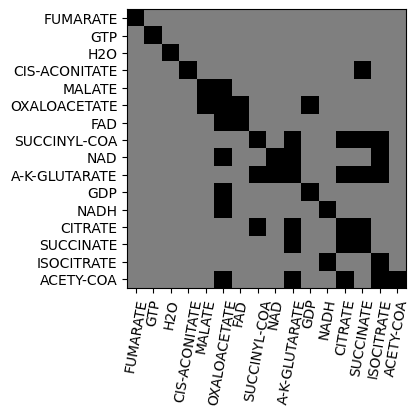

In [ ]:
plot_graph("series_graph_output.txt", "series_dynotears.pdf")

## Evaluations

### metrics-gcastle

In [ ]:
!pip install gcastle==1.0.3rc2

import pandas as pd
from castle.metrics import MetricsDAG


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
true_dag = pd.read_csv('result_groundtruth.csv', header=0, index_col=False).to_numpy()
#causal_matrix =pd.read_csv('result_dynotear.csv', header=0, index_col=False).to_numpy()
causal_matrix =pd.read_csv('result_dynotear.csv', header=0, index_col=False).to_numpy()
met = MetricsDAG(causal_matrix, true_dag)
met.metrics


DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


{'fdr': 0.7714,
 'tpr': 0.3704,
 'fpr': 0.2903,
 'shd': 43,
 'nnz': 35,
 'precision': 0.2,
 'recall': 0.2963,
 'F1': 0.2388,
 'gscore': 0.0}

### SHD, f1_scores-Petr

In [ ]:
# from dynotearstrain import train
import os

def read_graph(graph_file):
    with open(graph_file, "r") as file:
        lines = file.readlines()
    groundtruth = [tuple(line.strip().split()) for line in lines]
    return set(groundtruth)

def f1score(predictions, groundtruth):
    union = groundtruth.union(predictions)
    intersection = groundtruth.intersection(predictions)
    tp = len(intersection)
    fp = len(union) - len(groundtruth)
    fn = len(union) - len(predictions)
    return tp / (tp + (fp + fn) / 2)

dbns = read_graph("series_graph_output_dynotear.txt")

gts = read_graph("series_graph_output_groundtruth.txt")

# now compare with the ground truth graph
# dbns = set(dbn.edges)
edit_distances = len(gts.union(dbns)) - len(gts.intersection(dbns))
f1_scores = f1score(dbns, gts)
print(edit_distances, f1_scores)

54 0.4375


### Pytorch-Fbeta

In [ ]:
!pip install -q pytorch-ignite

In [ ]:
import os

in_colab = "COLAB_TPU_ADDR" in os.environ
with_torchrun = "WORLD_SIZE" in os.environ

if in_colab:
    VERSION = !curl -s https://api.github.com/repos/pytorch/xla/releases/latest | grep -Po '"tag_name": "v\K.*?(?=")'
    !pip install --upgrade -q cloud-tpu-client==0.10 torch=={VERSION[0]} torchvision https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-{VERSION[0][:-2]}-cp38-cp38-linux_x86_64.whl

!pip list | grep torch

pytorch-ignite                     0.5.1
torch                              2.4.1+cu121
torchaudio                         2.4.1+cu121
torchsummary                       1.5.1
torchvision                        0.19.1+cu121


In [ ]:
from ignite.metrics import Accuracy, Precision, Recall
from ignite.engine.engine import Engine
from ignite.metrics.fbeta import Fbeta

P = Precision(average=False)
R = Recall(average=False)
metric = Fbeta(beta=1.0, precision=P, recall=R)
f1 = (P * R * 2 / (P + R)).mean()
print(f1)
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)
metric.attach(default_evaluator, "f-beta")
true_dag = pd.read_csv('result_groundtruth.csv', header=0, index_col=False).to_numpy().reshape(-1)
causal_matrix =pd.read_csv('result_anmncpop.csv', header=0, index_col=False).to_numpy().reshape(-1)
y_true = torch.tensor(true_dag)
y_pred = torch.tensor(causal_matrix)
state = default_evaluator.run([[y_pred, y_true]])
print(P,R,state.metrics["f-beta"])

<ignite.metrics.precision.Precision object at 0x7cef32ac68f0> <ignite.metrics.recall.Recall object at 0x7cef32ac6ef0> 0.19178082191780776


In [ ]:
state.metrics

{'f-beta': 0.19178082191780776}

In [ ]:
from sklearn.metrics import precision_score, recall_score, fbeta_score

# 假设你有实际标签和预测标签
y_true = pd.read_csv('result_groundtruth.csv', header=0, index_col=False).to_numpy().reshape(-1)
y_pred = pd.read_csv('result_anmncpop.csv', header=0, index_col=False).to_numpy().reshape(-1)

# 计算Precision和Recall
P = precision_score(y_true, y_pred, average=None)
R = recall_score(y_true, y_pred, average=None)

# 计算F1-score (Fbeta with beta=1)
beta = 1.0
Fbeta = fbeta_score(y_true, y_pred, beta=beta, average=None)

print("Precision: ", P)
print("Recall: ", R)
print("Fbeta score: ", Fbeta)


Precision:  [0.84070796 0.23333333]
Recall:  [0.89201878 0.1627907 ]
Fbeta score:  [0.86560364 0.19178082]


### Causal Discovery Toolbox-SHD

In [ ]:
!pip install cdt uuid

In [ ]:
import cdt
import pandas as pd
from cdt.metrics import SHD
from numpy.random import randint
tar = pd.read_csv('result_groundtruth.csv', header=0, index_col=False).to_numpy()
pred =pd.read_csv('result_dynotear.csv', header=0, index_col=False).to_numpy()
SHD(tar, pred, double_for_anticausal=True)
# SHD(tar, pred, double_for_anticausal=False)
# SID(target=tar, pred=pred)

54.0

### nx.DiGraph-SHD

In [ ]:
def structural_hamming_distance(true_graph: nx.DiGraph, other_graph: nx.DiGraph):
    """Compute structural hamming distance between a pair of graphs.

    This implementation follows the definition from the following paper:
        Structural Intervention Distance (SID) for Evaluating Causal
        Graphs (Peters and Buhlmann, 2014), page 2.

    Informally, the structural hamming distance is the number of edges that must
    be changed (by removing, adding, or reversing its direction) to make the
    two DAGs structurally equivalent.

    :param true_graph: The true causal DAG.
    :param other_graph: The graph to compare against the true causal DAG.
    :returns: structural hamming distance.
    """
    true_edge_set = set(true_graph.edges)
    other_edge_set = set(other_graph.edges)
    exclusive_true_edges = true_edge_set - other_edge_set
    exclusive_other_edges = other_edge_set - true_edge_set
    return len(exclusive_true_edges) + len(exclusive_other_edges)

G_tar = nx.from_numpy_array(tar, create_using=nx.DiGraph)
G_pred = nx.from_numpy_array(pred, create_using=nx.DiGraph)
structural_hamming_distance(G_tar, G_pred)

54

## Backup

In [ ]:

class NCPOLR(object):
    """Estimator based on NCPOP Regressor

    References
    ----------
    Quan Zhou https://github.com/Quan-Zhou/Proper-Learning-of-LDS/blob/master/ncpop/functions.py

    Examples
    --------
    """

    def __init__(self, **kwargs):
        super(NCPOLR, self).__init__()


    def generate_operators(name, n_vars=1, hermitian=None, commutative=False):
        """Generates a number of commutative or noncommutative operators

        :param name: The prefix in the symbolic representation of the noncommuting
                    variables. This will be suffixed by a number from 0 to
                    n_vars-1 if n_vars > 1.
        :type name: str.
        :param n_vars: The number of variables.
        :type n_vars: int.
        :param hermitian: Optional parameter to request Hermitian variables .
        :type hermitian: bool.
        :param commutative: Optional parameter to request commutative variables.
                            Commutative variables are Hermitian by default.
        :type commutative: bool.

        :returns: list of :class:`sympy.physics.quantum.operator.Operator` or
                  :class:`sympy.physics.quantum.operator.HermitianOperator`
                  variables

        :Example:

        >>> generate_variables('y', 2, commutative=True)
        ￼[y0, y1]
        """

        variables = []
        for i in range(n_vars):
            if n_vars > 1:
                var_name = '%s%s' % (name, i)
            else:
                var_name = '%s' % name
            if hermitian is not None and hermitian:
                variables.append(HermitianOperator(var_name))
            else:
                variables.append(Operator(var_name))
            variables[-1].is_commutative = commutative
        return variables

    def estimate(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        X : array
            Variable seen as cause
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """

        T = len(Y)
        level = 1

        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)
        n = generate_operators("m", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.5*sum(p[i] for i in range(T))

        # Constraints
        ine1 = [f[i] - G*X[i] - n[i] for i in range(T)]
        ine2 = [-f[i] + G*X[i] + n[i] for i in range(T)]
        ine3 = [p[i]-n[i] for i in range(T)]
        ine4 = [p[i]+n[i] for i in range(T)]
        ines = ine1+ine2+ine3+ine4

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,f,n,p]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')
        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[n[i]])
            print(est_noise)
            return est_noise
        else:
            print('Cannot find feasible solution.')
            return

    def estimate2(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """
        Y = np.transpose(Y)
        T = len(Y)-1
        level = 1


        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        Fdash = generate_operators("Fdash", n_vars=1, hermitian=True, commutative=False)[0]
        # m = generate_operators("m", n_vars=T+1, hermitian=True, commutative=False)
        q = generate_operators("q", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.001*sum(p[i]**2 for i in range(T)) + 0.0005*sum(q[i]**2 for i in range(T))

        #c1*sum(p[i]**2 for i in range(T)) + c2*sum(q[i]**2 for i in range(T))

        # Constraints
        ine1 = [f[i] - Fdash*X[i+1] - p[i] for i in range(T)]
        ine2 = [-f[i] + Fdash*X[i+1] + p[i] for i in range(T)]
        ine3 = [X[i+1] - G*X[i] - q[i] for i in range(T)]
        ine4 = [-X[i+1] + G*X[i] + q[i] for i in range(T)]
        #ine5 = [(Y[i]-f[i])**2 for i in range(T)]
        ines = ine1+ine2+ine3+ine4 #+ine5

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,Fdash,f,p,q]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')

        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[p[i]])
            print(est_noise)
            return est_noise
        else:
            print('Cannot find feasible solution.')
            return


class ANM_NCPO():
    """
    Nonlinear causal discovery with additive noise models

    Use Estimator based on NCPOP Regressor and independent Gaussian noise,
    For the independence test, we implemented the HSIC with a Gaussian kernel,
    where we used the gamma distribution as an approximation for the
    distribution of the HSIC under the null hypothesis of independence
    in order to calculate the p-value of the test result.

    References
    ----------
    Hoyer, Patrik O and Janzing, Dominik and Mooij, Joris M and Peters,
    Jonas and Schölkopf, Bernhard,
    "Nonlinear causal discovery with additive noise models", NIPS 2009

    Parameters
    ----------
    alpha : float, default 0.05
        significance level be used to compute threshold

    Attributes
    ----------
    causal_matrix : array like shape of (n_features, n_features)
        Learned causal structure matrix.

    Examples
    --------
    """

    def __init__(self, alpha=0.05):
        super(ANM_NCPO, self).__init__()
        self.alpha = alpha

    def learn(self, data, columns=None, regressor=NCPOLR(),test_method=CITest.hsic_test, **kwargs):
        """Set up and run the ANM_NCPOP algorithm.

        Parameters
        ----------
        data: numpy.ndarray
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOLR.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        """

        self.regressor = regressor
        # data = Tensor(data, columns=columns)

        node_num = data.shape[0]
        self.causal_matrix = np.zeros((node_num, node_num))

        for i, j in combinations(range(node_num), 2):
            x = data[i, :, :]
            y = data[j, :, :]
            xx = x.reshape((-1, 1))
            yy = y.reshape((-1, 1))

            flag = test_method(xx, yy, alpha=self.alpha)
            if flag == 1:
                continue
            # test x-->y
            flag = self.ANMNCPO_fitness(x, y, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[i, j] = 1
            # test y-->x
            flag = self.ANMNCPO_fitness(y, x, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[j, i] = 1

    def ANMNCPO_fitness(self, x, y, regressor=NCPOLR(), test_method=CITest.hsic_test):
        """Compute the fitness score of the ANM_NCPOP Regression model in the x->y direction.

        Parameters
        ----------
        x: array
            Variable seen as cause
        y: array
            Variable seen as effect
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOP.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        Returns
        -------
        out: int, 0 or 1
            If 1, residuals n is independent of x, then accept x --> y
            If 0, residuals n is not independent of x, then reject x --> y

        """

        x = scale(x).reshape(-1)
        y = scale(y).reshape(-1)

        y_res = regressor.estimate(x, y)
        flag = test_method(np.asarray(y_res).reshape((-1, 1)), np.asarray(x).reshape((-1, 1)), alpha=self.alpha)

        print(flag)

        return flag


### SID(Structural Intervention Distance)

In [ ]:
!apt-get install -y libgmp-dev libmpfr-dev libgsl-dev

!R -e "install.packages('graph')"
!R -e "install.packages('RBGL')"
!R -e "install.packages('ggm')"
!R -e "install.packages('pcalg')"
!R -e "install.packages('SID')"
!R -e "install.packages('init')"
!R -e "install.packages('kpcalg')"
!R -e "install.packages('bnlearn')"
!R -e "install.packages('sparsebn')"
!R -e "install.packages('CAM')"
!R -e "install.packages('RCIT')"




Streaming output truncated to the last 5000 lines.
../inst/include/RMatOp/RealShift_sparseMatrix.h:31:10:   required from here
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/CoreEvaluators.h:1071:54: warning: ignoring attributes on template argument ‘Eigen::internal::packet_traits<double>::type’ {aka ‘__m128d’} []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wignored-attributes-Wignored-attributes]8;;]
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/CoreEvaluators.h: In instantiation of ‘struct Eigen::internal::evaluator<Eigen::Block<Eigen::Map<Eigen::Matrix<double, 2, 1>, 0, Eigen::Stride<0, 0> >, 0, 1, false> >’:
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/CoreEvaluators.h:100:8:   required from ‘struct Eigen::internal::evaluator<const Eigen::Block<Eigen::Map<Eigen::Matrix<double, 2, 1>, 0, Eigen::Stride<0, 0> >, 0, 1, false> >’
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/CoreEvaluators.h:739:

In [ ]:
print(cdt.utils.R.RPackages)
print(cdt.RPackages.check_R_package('SID'))

['init: False', 'pcalg: False', 'kpcalg: False', 'bnlearn: False', 'sparsebn: False', 'D2C: False', 'SID: False', 'CAM: False', 'RCIT: False']
False


### Precision SID SHD

In [ ]:
# from cdt.metrics import (precision_recall, SID, SHD)
import numpy as np
import pandas as pd
from pathlib import Path
import networkx as nx
import uuid
from shutil import rmtree
from cdt.utils.R import launch_R_script, RPackages
from tempfile import gettempdir

def retrieve_adjacency_matrix(graph, order_nodes=None, weight=False):
    """Retrieve the adjacency matrix from the nx.DiGraph or numpy array."""
    if isinstance(graph, np.ndarray):
        return graph
    elif isinstance(graph, nx.DiGraph):
        if order_nodes is None:
            order_nodes = graph.nodes()
        if not weight:
            return np.array(nx.adjacency_matrix(graph, order_nodes, weight=None).todense())
        else:
            return np.array(nx.adjacency_matrix(graph, order_nodes).todense())
    else:
        raise TypeError("Only networkx.DiGraph and np.ndarray (adjacency matrixes) are supported.")



def SID(target, pred):
    """Compute the Strutural Intervention Distance.

    [R wrapper] The Structural Intervention Distance (SID) is a new distance
    for graphs introduced by Peters and Bühlmann (2013). This distance was
    created to account for the shortcomings of the SHD metric for a causal
    sense.
    It consists in computing the path between all the pairs of variables, and
    checks if the causal relationship between the variables is respected.
    The given graphs have to be DAGs for the SID metric to make sense.

    **Required R packages**: SID

    Args:
        target (numpy.ndarray or networkx.DiGraph): Target graph, must be of
            ones and zeros, and instance of either numpy.ndarray or
            networkx.DiGraph. Must be a DAG.

        prediction (numpy.ndarray or networkx.DiGraph): Prediction made by the
            algorithm to evaluate. Must be a DAG.

    Returns:
        int: Structural Intervention Distance.

            The value tends to zero as the graphs tends to be identical.

    .. note::
        Ref: Structural Intervention Distance (SID) for Evaluating Causal Graphs,
        Jonas Peters, Peter Bühlmann: https://arxiv.org/abs/1306.1043

    Examples:
        >>> from cdt.metrics import SID
        >>> from numpy.random import randint
        >>> tar = np.triu(randint(2, size=(10, 10)))
        >>> pred = np.triu(randint(2, size=(10, 10)))
        >>> SID(tar, pred)
   """
    true_labels = retrieve_adjacency_matrix(target)
    predictions = retrieve_adjacency_matrix(pred, target.nodes()
                                            if isinstance(target, nx.DiGraph) else None)

    base_dir = Path('{0!s}/cdt_SID_{1!s}'.format(gettempdir(), uuid.uuid4()))
    os.makedirs(base_dir)

    def retrieve_result():
        return np.loadtxt(Path('{0!s}/result.csv'.format(base_dir)))

    try:
        np.savetxt(Path('{}/target.csv'.format(base_dir)), true_labels, delimiter=',')
        np.savetxt(Path('{}/pred.csv'.format(base_dir)), predictions, delimiter=',')
        sid_score = launch_R_script(Path("{}/utils/R_templates/sid.R".format(os.path.dirname(os.path.realpath(__file__)))),
                                    {"{target}": Path('{}/target.csv'.format(base_dir)),
                                     "{prediction}": Path('{}/pred.csv'.format(base_dir)),
                                     "{result}": Path('{}/result.csv'.format(base_dir))},
                                    output_function=retrieve_result)
    # Cleanup
    except Exception as e:
        rmtree(base_dir)
        raise e
    except KeyboardInterrupt:
        rmtree(base_dir)
        raise KeyboardInterrupt

    rmtree(base_dir)
    return sid_score

graph = pd.read_csv('result_groundtruth.csv', header=0, index_col=False).to_numpy()
output_graph =pd.read_csv('result_dynotear.csv', header=0, index_col=False).to_numpy()
SID(graph, output_graph)
# scores = [metric(graph, output_graph) for metric in (precision_recall, SID, SHD)]
# print(scores)

TypeError: realpath() missing 1 required positional argument: 'filename'

In [ ]:
# now we compute the CAM graph without constraints and the associated scores

scores_nc = [metric(graph, output_graph_nc) for metric in (precision_recall, SID, SHD)]
print(scores_nc)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample Data Generation
optimization_steps = np.arange(1, 31)
# Simulate objective scores for different methods
string_ga = np.random.normal(loc=5.8, scale=0.1, size=len(optimization_steps))
string_rs = np.random.normal(loc=5.5, scale=0.2, size=len(optimization_steps))
feature_ga = np.random.normal(loc=5.0, scale=0.3, size=len(optimization_steps))
feature_rs = np.random.normal(loc=4.8, scale=0.3, size=len(optimization_steps))
linear_ga = np.random.normal(loc=4.5, scale=0.2, size=len(optimization_steps))
linear_rs = np.random.normal(loc=4.2, scale=0.25, size=len(optimization_steps))
rs = np.random.normal(loc=3.8, scale=0.15, size=len(optimization_steps))

# Simulate standard deviations for error bands
std = np.random.normal(loc=0.1, scale=0.02, size=len(optimization_steps))

# Computational overhead data for the bar plot
methods = ['SSK(ga)', 'SSK(rs)', 'Feature(ga)', 'Feature(rs)', 'Linear(ga)', 'Linear(rs)', 'RS']
overhead = [0.01, 0.03, 0.002, 0.02, 0.05, 0.07, 0.001]  # in seconds

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

# Plot the line plot with error bands
ax1.plot(optimization_steps, string_ga, 'b-', label='String(ga)', marker='^')
ax1.fill_between(optimization_steps, string_ga - std, string_ga + std, color='blue', alpha=0.2)
ax1.plot(optimization_steps, string_rs, 'b--', label='String(rs)', marker='o')
ax1.fill_between(optimization_steps, string_rs - std, string_rs + std, color='blue', alpha=0.2)

ax1.plot(optimization_steps, feature_ga, 'g-', label='Feature(ga)', marker='s')
ax1.fill_between(optimization_steps, feature_ga - std, feature_ga + std, color='green', alpha=0.2)
ax1.plot(optimization_steps, feature_rs, 'g--', label='Feature(rs)', marker='x')
ax1.fill_between(optimization_steps, feature_rs - std, feature_rs + std, color='green', alpha=0.2)

ax1.plot(optimization_steps, linear_ga, 'm-', label='Linear(ga)', marker='p')
ax1.fill_between(optimization_steps, linear_ga - std, linear_ga + std, color='magenta', alpha=0.2)
ax1.plot(optimization_steps, linear_rs, 'm--', label='Linear(rs)', marker='*')
ax1.fill_between(optimization_steps, linear_rs - std, linear_rs + std, color='magenta', alpha=0.2)

ax1.plot(optimization_steps, rs, 'k-', label='RS', marker='.')
ax1.fill_between(optimization_steps, rs - std, rs + std, color='black', alpha=0.2)

# Add labels and legends
ax1.set_xlabel('# Optimization Steps')
ax1.set_ylabel('Achieved Objective Score')
ax1.legend(loc='best')

# Plot the bar plot with computational overhead
ax2.barh(methods, overhead, color=['blue', 'blue', 'green', 'green', 'magenta', 'magenta', 'black'])
ax2.set_xscale('log')  # Use a log scale for computational overhead
ax2.set_xlabel('Computational Overhead (secs)')

# Show the plot
plt.tight_layout()
plt.show()
